# 04 PyTorch Custom Datasets
How do you get your own data into PyTorch?

One way is to use custom datasets using PyTorch

In [1]:
import torch
from torch import nn 

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device 

'cuda'

## 1. Get Data
Our data is a subset of Food101 datasets

Food101 starts 101 different classes of food and 1000 images oer class (750 training, 250 testing)

Our dataset starts with 3 classes of food and only 10% of the images (~75 training, 25 testing)

Why do this?
* When starting out ML projects, it's important to try things on a small scale and then increase the scale when necessary.
* The whole point is to speed up how fast you can experiment.

In [3]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder.
data_path= Path('data/')
image_path= data_path/"pizza_stake_sushi"

# If the image folder doesn't exist, download it and prepare it.
if image_path.is_dir():
    print(f"{image_path} dir already exists, skipping download...")
else:
    print(f"{image_path} directory does not exist, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

# Download the pizza, stake and sushi data
with open(data_path/"pizza_stake_sushi.zip", 'wb') as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading pizza, stake, sushi data...")
    f.write(request.content)

# Unzip pizza stake and sushi data
with zipfile.ZipFile(data_path/'pizza_stake_sushi.zip', 'r') as zip_ref:
    print("Unzipping pizza, stake and sushi data...")
    zip_ref.extractall(image_path)


data\pizza_stake_sushi dir already exists, skipping download...
Unzipping pizza, stake and sushi data...


## 2. Data Prepration and Exploration

In [4]:
import os 
def walk_through_dir(dir_path):
    '''Walks through dir_path returning its content'''
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [5]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data\pizza_stake_sushi'.
There are 3 directories and 0 images in 'data\pizza_stake_sushi\test'.
There are 0 directories and 25 images in 'data\pizza_stake_sushi\test\pizza'.
There are 0 directories and 19 images in 'data\pizza_stake_sushi\test\steak'.
There are 0 directories and 31 images in 'data\pizza_stake_sushi\test\sushi'.
There are 3 directories and 0 images in 'data\pizza_stake_sushi\train'.
There are 0 directories and 78 images in 'data\pizza_stake_sushi\train\pizza'.
There are 0 directories and 75 images in 'data\pizza_stake_sushi\train\steak'.
There are 0 directories and 72 images in 'data\pizza_stake_sushi\train\sushi'.


In [6]:
# Setup train and test paths
train_dir= image_path/'train'
test_dir= image_path/'test'  

train_dir, test_dir

(WindowsPath('data/pizza_stake_sushi/train'),
 WindowsPath('data/pizza_stake_sushi/test'))

### 2.1 Visualise an Image
* Get all of the image paths
* Pick a random image using Python's `random.choice()`
* Get the image class names using `pathlib.Path.parent.stem`
* Since we're working with images, let's open the image with Python's PIL
* Show the image and the meta-data

In [7]:
image_path

WindowsPath('data/pizza_stake_sushi')

data\pizza_stake_sushi\test\sushi\2394442.jpg
sushi
Random image path: data\pizza_stake_sushi\test\sushi\2394442.jpg
IImage Class: sushi
Imahe height: 408
Image width: 512


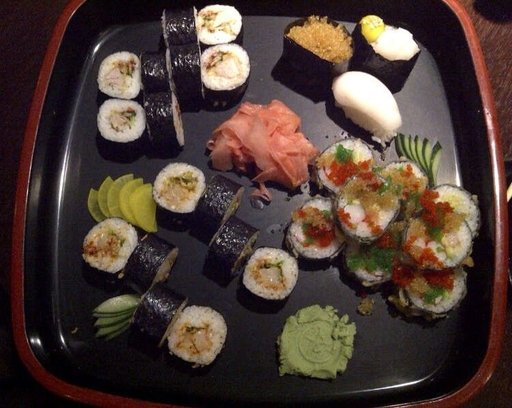

In [8]:
import random
from PIL import Image

# Set seed
random.seed(42)

# Get all image paths
image_path_list= list(image_path.glob('*/*/*.jpg'))

# Pick a random image path
random_image_path= random.choice(image_path_list)
print(random_image_path)

# Get image class from path name
image_class= random_image_path.parent.stem
print(image_class)

# Open image 
img= Image.open(random_image_path)

# Print image metadata
print(f"Random image path: {random_image_path}")
print(f"IImage Class: {image_class}")
print(f"Imahe height: {img.height}")
print(f"Image width: {img.width}")
img

(-0.5, 511.5, 407.5, -0.5)

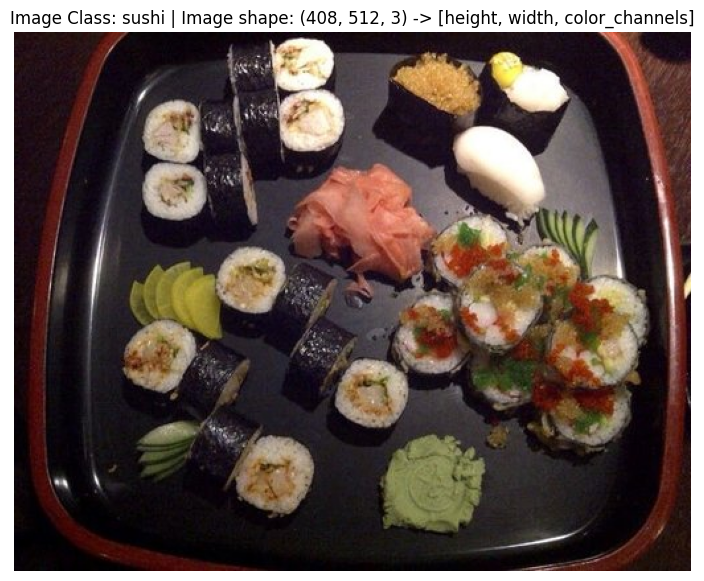

In [9]:
import numpy as np 
import matplotlib.pyplot as plt 

# Turn the images into an array 
img_as_array= np.asarray(img)

# Plot image
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image Class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False)

## 3. Transforming data
Before we can use image as data:
1. Turn target data into tensor
2. turn it into `torch.utils.data.Dataset` and subsequently `torch.utils.data.DataLoader`

### 3.1 Transforming data with `torchvision.transforms`
Transforms help get the image ready to be used with a model/perform data augmentation.

In [10]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Write a transfor for image
data_transform= transforms.Compose([
    # Resize our image to 64x64 
    transforms.Resize(size=(64, 64)),
    # Flip the image randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image to torch tensor
    transforms.ToTensor()
])

In [11]:
data_transform(img)

tensor([[[0.0824, 0.0824, 0.0863,  ..., 0.1412, 0.1373, 0.1294],
         [0.0902, 0.0902, 0.0902,  ..., 0.1412, 0.1373, 0.1255],
         [0.1137, 0.0980, 0.1059,  ..., 0.1333, 0.1412, 0.1294],
         ...,
         [0.1412, 0.1373, 0.1294,  ..., 0.0157, 0.0196, 0.0157],
         [0.1333, 0.1373, 0.1255,  ..., 0.0275, 0.0275, 0.0275],
         [0.1255, 0.1294, 0.1137,  ..., 0.0275, 0.0314, 0.0314]],

        [[0.0431, 0.0431, 0.0392,  ..., 0.0667, 0.0588, 0.0588],
         [0.0353, 0.0431, 0.0392,  ..., 0.0667, 0.0549, 0.0588],
         [0.0392, 0.0471, 0.0471,  ..., 0.0627, 0.0627, 0.0510],
         ...,
         [0.0667, 0.0667, 0.0667,  ..., 0.0078, 0.0078, 0.0039],
         [0.0667, 0.0706, 0.0706,  ..., 0.0118, 0.0118, 0.0118],
         [0.0667, 0.0667, 0.0667,  ..., 0.0196, 0.0157, 0.0118]],

        [[0.0745, 0.0706, 0.0706,  ..., 0.0667, 0.0667, 0.0667],
         [0.0863, 0.0902, 0.0941,  ..., 0.0863, 0.0784, 0.0784],
         [0.1137, 0.1059, 0.0941,  ..., 0.0941, 0.0863, 0.

In [12]:
def plot_transformed_images(image_paths, transform, n=3, seed=None):
    '''Selects random images from a path of images and loads/transforms them and then plots the orignal vs transformed version.'''
    if seed:
        random.seed(seed)
    random_image_paths= random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(f)
            ax[0].set_title(f"Orignal \nSize: {f.size}")
            ax[0].axis(False)

            # Transform and plot target image
            transformed_img= data_transform(f).permute(1,2,0) # will change the order of the dim to [color_channel, height, width]
            ax[1].imshow(transformed_img)
            ax[1].set_title(f"Transformed\nSize: {transformed_img.shape}")
            ax[1].axis(False)

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize= 16)

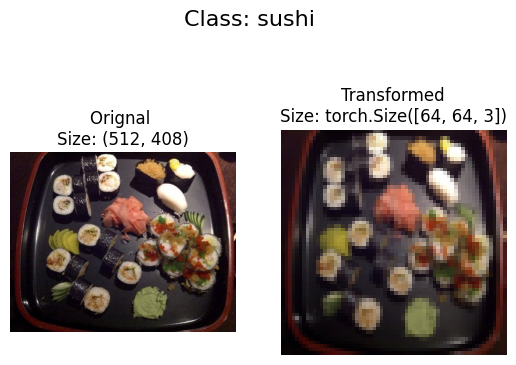

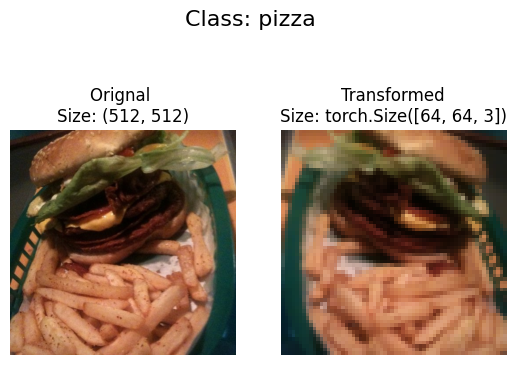

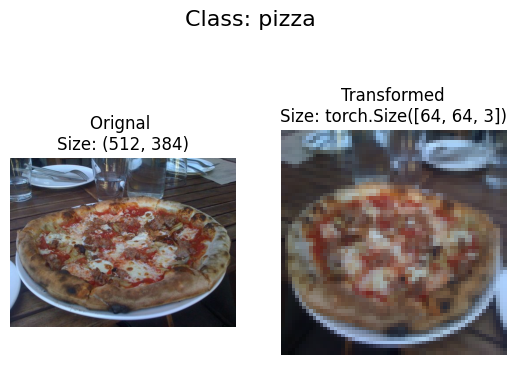

In [13]:
plot_transformed_images(image_paths= image_path_list,
                       transform= data_transform,
                       n=3, 
                       seed= 42)

## 4.1 Load image data using `ImageFolder`
We can load image classification data using `torchvision.datasets.ImageFolder`.

In [14]:
# Use ImageFolder to create datasets
train_data= datasets.ImageFolder(root=train_dir,
                                transform=data_transform,
                                target_transform=None)
test_data= datasets.ImageFolder(root=test_dir,
                                transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data\pizza_stake_sushi\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data\pizza_stake_sushi\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [15]:
# Get class names as list
class_names= train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [16]:
# Get class names as dict
class_dict= train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [17]:
# Check length of our datasets
len(train_data), len(test_data)

(225, 75)

In [18]:
# Index on train_data Datasets ti get a single image and label
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor: {img}")
print(f"Image Shape: {img.shape}")
print(f"Image Datatype: {img.dtype}")
print(f"Image Label: {label}")
print(f"Image Label Datatype: {type(label)}")

Image tensor: tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.09

Orignal Shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image Permute: tensor([[[0.1176, 0.0588, 0.0196],
         [0.1216, 0.0588, 0.0196],
         [0.1255, 0.0588, 0.0157],
         ...,
         [0.0980, 0.0745, 0.0902],
         [0.1020, 0.0706, 0.0902],
         [0.1137, 0.0745, 0.0941]],

        [[0.1294, 0.0627, 0.0196],
         [0.1294, 0.0627, 0.0157],
         [0.1294, 0.0627, 0.0196],
         ...,
         [0.0980, 0.0745, 0.0902],
         [0.0980, 0.0706, 0.0863],
         [0.1059, 0.0745, 0.0902]],

        [[0.1333, 0.0706, 0.0196],
         [0.1333, 0.0706, 0.0157],
         [0.1333, 0.0706, 0.0157],
         ...,
         [0.0941, 0.0745, 0.0902],
         [0.0980, 0.0745, 0.0902],
         [0.1020, 0.0706, 0.0902]],

        ...,

        [[0.1686, 0.2392, 0.1843],
         [0.1647, 0.2392, 0.1882],
         [0.1686, 0.2510, 0.1961],
         ...,
         [0.1255, 0.1373, 0.1490],
         [0.1098, 0.1333, 0.1333],
         [0.1098, 0.1255, 0.12

Text(0.5, 1.0, 'pizza')

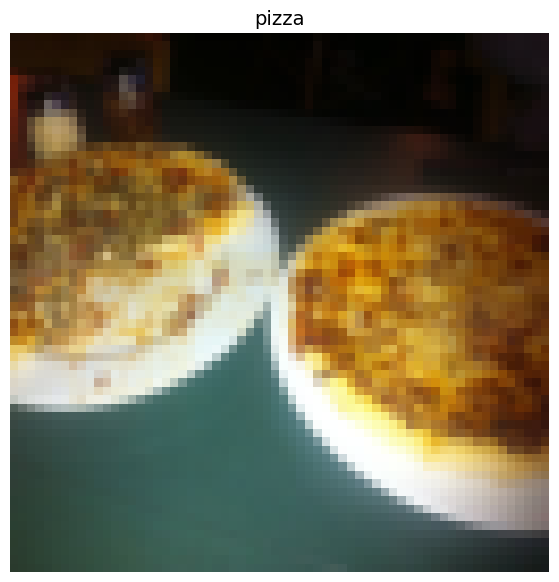

In [19]:
# Rearragne the order dimensions
img_permute= img.permute(1,2,0)

print(f"Orignal Shape: {img.shape} -> [color_channels, height, width]")
print(f"Image Permute: {img_permute} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10,7))
plt.imshow(img_permute)
plt.axis(False)
plt.title(class_names[label], fontsize= 14)


### 4.1 Turn loaded images into `DataLoader`s
A `DataLoader` is going to turn our `Datasets` into iterables and we can custom 

In [20]:
# Turn train and test datasets into Dataloader
BATCH_SIZE= 1
train_dataloader= DataLoader(dataset=train_data,
                             batch_size=BATCH_SIZE,
                             num_workers=1,
                             shuffle=True)

test_dataloader= DataLoader(dataset=test_data,
                            batch_size=BATCH_SIZE,
                            num_workers=1,
                            shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x1ecb0098410>,
 <torch.utils.data.dataloader.DataLoader at 0x1ecb01f0ad0>)

In [21]:
len(train_dataloader), len(test_dataloader)

(225, 75)

In [22]:
img, label= next(iter(train_dataloader))

print(f"Image Shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Image Label: {label.shape}")

Image Shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Image Label: torch.Size([1])


## 5. Loading Image Data with a custom datasets
1. Want to be able to load images from file
2. Want to be able to get class_names from the Dataset
3. Want to be able to get classes as dictionary from the Dataset

Pros:
* Can create a `Dataset` out of almost anything
* Not limited to PyTirch pre-built `Dataset` functions

Cons: 
* Eventhough we can create `Dataset` out of anything, doesn't mean that it would work.
* Using a custom `Dataset` often results in us writing more code, which could be prone to errors or performance issues

All custom datasets in PyTorch often subclass - https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset

In [23]:
import os
import torch
import pathlib

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [24]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating helper function to get class names
We want a function to:
1. Get class names using `os.scandir()` to travers a target directory(ideally the dir is in standard image classification format).
2. Raise an error if the class names aren't found (if this happens, there might be something wrong with the directory structure).
3. Turn the class names into a dict and a list and return them

In [25]:
# Setup path for target directory
target_directory= train_dir
print(f"Target Directory: {target_directory}")

# Get the class names from the target dirctory
class_names_found= sorted(entry.name for entry in list(os.scandir(target_directory)))
class_names_found

Target Directory: data\pizza_stake_sushi\train


['pizza', 'steak', 'sushi']

In [26]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, str]]:
    '''Finds the class folder names in a target directory'''
    # 1. Get the class names by scanning the target directory
    classes= sorted(entry.name for entry in os.scandir(target_directory) if entry.is_dir())

    # 2. Raise an error if class names could not be found
    if not classes:
        raise FileNotFoundError(f"Couldn't fond any classes in {directory}... Please check file structure.") 
    
    # 3. Create a directory of index labels
    classes_to_idx= {class_names: i for i, class_names in enumerate(classes)}
    return classes, classes_to_idx

In [27]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom `Dataset` to replicat `ImageFolder`
To create our own custom dataset, we want to:
1. Subclass `torch.utils.data.Dataset`
2. Init our subclass with a target directory as well as transform if we'd like to transform our data.
3. Create several attributes:
    * paths- paths of our images
    * transform- transforms we'd like to use
    * classes- a list of the target classes
    * classes_to_idx- a dict of the target classes mapped to integer labels
4. Create a function to `load_images()`, this function will open an image.
5. Overwrite the `__len__()` method to return the length of our datasets.
6. Overwrite the `__getitem__()` method to return a given sample when passed an index

In [28]:
# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
    # 2. Initialise our custom dataset
    def __init__(self,
                 targ_dir: str,
                 transform= None):
        # 3. Create class attributes
        # Get all of the image paths
        self.paths= list(pathlib.Path(targ_dir).glob("*/*.jpg"))
        # Setup transfor
        self.transform= transform
        # Create classes abd class_to_idx
        self.classes, self.class_to_idx= find_classes(targ_dir)

    # 4. Create a function to load images
    def load_image(self, index: int) -> Image.Image:
        '''Opens an image via a path and returns it'''
        image_path= self.paths[index]
        return Image.open(image_path)
    
    # 5. Overwrite __len__()
    def __len__(self) -> int:
        '''Returns the total number of samples.'''
        return len(self.paths)
    
    # 6. Overwrite __getitem__() to return a particular sample
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        '''Returns one sample of data, data and label (X,y)'''
        img= self.load_image(index)
        class_name= self.paths[index].parent.name # expects path in format: data_folder/class_name/image.jpg
        class_idx= self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx # return data, label (X,y)
        else:
            return img, class_idx # returns untransformed image and label

In [29]:
train_transform= transforms.Compose([transforms.Resize((64,64)),
                                     transforms.RandomHorizontalFlip(p=0.5),
                                     transforms.ToTensor()])

test_transform= transforms.Compose([transforms.Resize((64,64)),
                                    transforms.ToTensor()])

In [30]:
# Test out ImageFolderCustom
train_data_custom= ImageFolderCustom(targ_dir= train_dir,
                                     transform= train_transform)
test_data_custom= ImageFolderCustom(targ_dir=test_dir,
                                    transform=test_transform)

In [31]:
# Check for equality amongst our custom Dataset and ImageFolder Dataset
print((len(train_data_custom) == len(train_data)) & (len(test_data_custom) == len(test_data)))
print(train_data_custom.classes == train_data.classes)
print(train_data_custom.class_to_idx == train_data.class_to_idx)

True
True
True


### 5.3 Create a function to display random images
1. Take in a `Dataset` and a number of parameters such as class names and how many images to visualise
2. To prevent the display getting out of hand, let's cap the images to 10.
3. Set a random seed for reproducibility.
4. Get a list of random smaple indexes from the target dataset.
5. Set a matplotlib plot
6. Loop through the random sample images and plot them with matplotlib.
7. Make sure the dimensions of our images lineup with matplotlib (HWC)

In [32]:
def display_radom_images(dataset: torch.utils.data.Dataset,
                         classes: List [str]= None,
                         n: int =10,
                         display_shape: bool= True,
                         seed:int= None ):
    # Adjust display if n > 10:
    if n>10:
        n=10
        display_shape= False
        print("For display purposes, n shouldn't be greater that 10 setting it to 10")

    # Setting seed
    if seed:
        random.seed(seed)

    # Get random sample of indexes
    random_sample_idx= random.sample(range(len(dataset)), k=n)

    # Setup plot
    plt.figure(figsize=(16,8))

    # Loop through random indexes and plot rthem with matplotlib
    for i, target_sample in enumerate(random_sample_idx):
        target_image, target_label= dataset[target_sample][0], dataset[target_sample][1]

        # Adjust tensor dimensions
        target_image_adjust= target_image.permute(1,2,0)

        # Plot Image
        plt.subplot(1, n, i+1)
        plt.imshow(target_image_adjust)
        plt.axis(False)
        if classes:
            title= f"Class: {classes[target_label]}"
            if display_shape:
                title= title + f"\nShape: {target_image_adjust.shape}"
        plt.title(title)

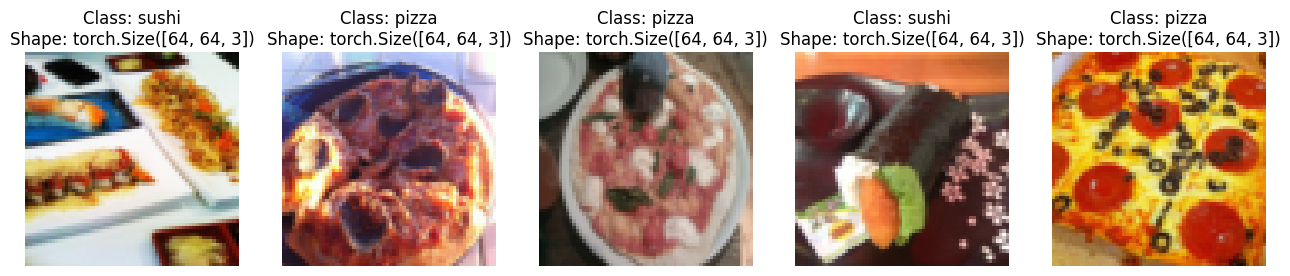

In [33]:
# Display random images from the ImageFolder Dataset
display_radom_images(dataset=train_data, n=5, classes=class_names, seed=42)

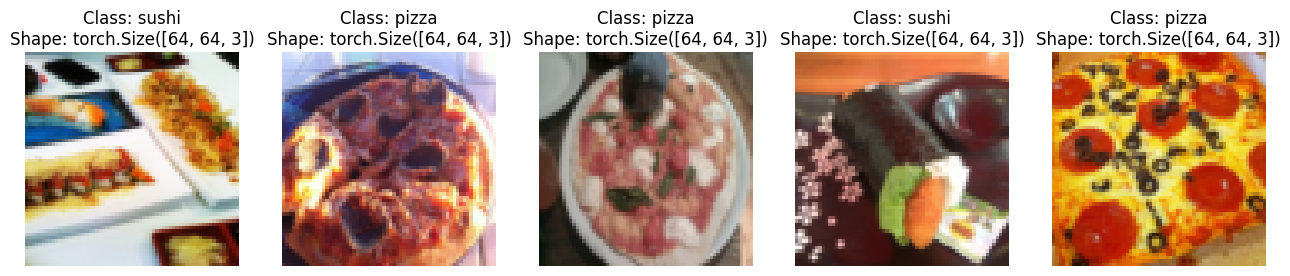

In [34]:
display_radom_images(dataset= train_data_custom, n=5, classes=class_names, seed= 42)

### 5.4 Turn Custom Dataset into Dataloader

In [35]:
BATCH_SIZE= 1
train_dataloader_custom= DataLoader(dataset=train_data_custom,
                                    batch_size= BATCH_SIZE,
                                    shuffle= True,
                                    num_workers=0)

test_dataloader_custom= DataLoader(dataset= test_data_custom,
                                   batch_size= BATCH_SIZE,
                                   shuffle= False,
                                   num_workers=0)
train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x1ecb021a210>,
 <torch.utils.data.dataloader.DataLoader at 0x1ecb054f2d0>)

In [36]:
# Get image and label from custom DataLoader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label_custom.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


## 6. Data augmentation
Data augmentation is the process of artificially adding diversity to your training data.
In case of image data, this may mean applying various image transformations to the training images.

This practice hopefully results in a model that's more geralizable to unseen data.

Let's take a look at one particular type of data augmentation used to train PyTorch's vision models to state of the art levels... 

In [37]:
# Trying trivial augment
train_transform= transforms.Compose([
    transforms.Resize(size= (224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform= transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor()
])

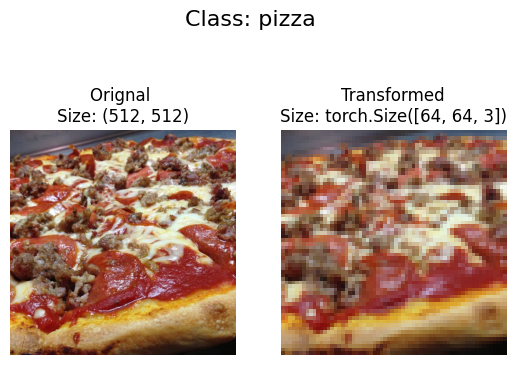

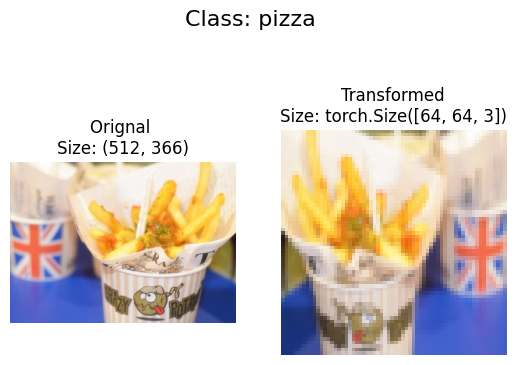

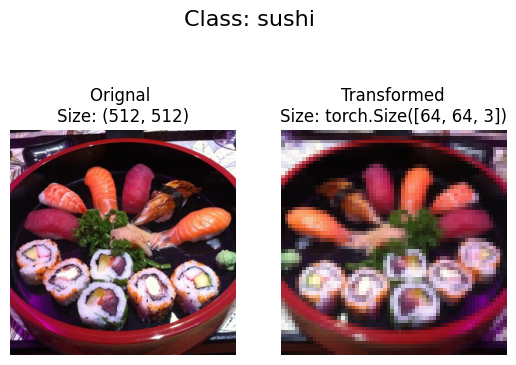

In [38]:
plot_transformed_images(
    image_paths=image_path_list,
    transform= train_transform,
    n=3,
    seed= None
)

## 7. Model 0: Tiny VGG without data augmentation

### 7.1 Creating transforms and loading data into Model0

In [39]:
# Creating simple transform
simple_transform= transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [40]:
train_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform= simple_transform
                                        )
test_data_simple= datasets.ImageFolder(root=test_dir,
                                       transform=simple_transform)

BATCH_SIZE= 32
NUM_WORKERS= os.cpu_count()

train_dataloader_simple= DataLoader(dataset=train_data_simple,
                                    batch_size= BATCH_SIZE,
                                    shuffle= True,
                                    num_workers= NUM_WORKERS
                                    )

test_dataloader_simple= DataLoader(dataset=test_data_simple,
                                   batch_size= BATCH_SIZE,
                                   shuffle=False,
                                   num_workers=NUM_WORKERS)

In [41]:
from torch import nn
class TinyVGG(nn.Module):
    def __init__(self,
                 input_shape: int,
                 output_shape: int,
                 hidden_units: int= 10) -> None:
        super().__init__()
        self.conv_block_1= nn.Sequential(
            nn.Conv2d(in_channels= input_shape,
                      out_channels= hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_block_2= nn.Sequential(
            nn.Conv2d(in_channels= hidden_units,
                      out_channels= hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier_layer= nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*13*13,
                      out_features=output_shape)
        )

    def forward(self, x):
        x= self.conv_block_1(x)
        x= self.conv_block_2(x)
        # print(x.shape)
        x= self.classifier_layer(x) 
        # print(x.shape)
        return x

In [42]:
model_0= TinyVGG(input_shape=3, # we have colored images therefore the input shape is 3
                 output_shape= len(class_names),
                 hidden_units=10).to(device= device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier_layer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [43]:
# Get a single image batch
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch, label_batch

(tensor([[[[0.1490, 0.1647, 0.1922,  ..., 0.9255, 0.8510, 0.7922],
           [0.1725, 0.1765, 0.1922,  ..., 0.7059, 0.7765, 0.8706],
           [0.1843, 0.1804, 0.1843,  ..., 0.7098, 0.8235, 0.8863],
           ...,
           [0.6353, 0.6196, 0.5529,  ..., 0.8510, 0.8510, 0.8471],
           [0.6392, 0.6314, 0.6000,  ..., 0.8588, 0.8510, 0.8392],
           [0.6431, 0.6353, 0.6196,  ..., 0.8549, 0.8392, 0.8118]],
 
          [[0.1098, 0.1294, 0.1569,  ..., 0.9294, 0.8549, 0.7843],
           [0.1333, 0.1412, 0.1569,  ..., 0.6980, 0.7725, 0.8667],
           [0.1490, 0.1451, 0.1490,  ..., 0.6980, 0.8118, 0.8824],
           ...,
           [0.6118, 0.6000, 0.5333,  ..., 0.8235, 0.8235, 0.8196],
           [0.6118, 0.6039, 0.5765,  ..., 0.8314, 0.8235, 0.8118],
           [0.6078, 0.6039, 0.5961,  ..., 0.8275, 0.8118, 0.7843]],
 
          [[0.1451, 0.1490, 0.1686,  ..., 0.9137, 0.8235, 0.7490],
           [0.1608, 0.1569, 0.1725,  ..., 0.6824, 0.7529, 0.8353],
           [0.1686, 0.16

In [44]:
model_0(image_batch.to(device))

tensor([[-0.0769, -0.0044,  0.0276],
        [-0.0734, -0.0046,  0.0306],
        [-0.0710, -0.0057,  0.0264],
        [-0.0762, -0.0055,  0.0294],
        [-0.0746, -0.0054,  0.0304],
        [-0.0749, -0.0040,  0.0287],
        [-0.0730, -0.0076,  0.0299],
        [-0.0732, -0.0032,  0.0271],
        [-0.0770, -0.0039,  0.0283],
        [-0.0735, -0.0070,  0.0283],
        [-0.0743, -0.0038,  0.0293],
        [-0.0773, -0.0088,  0.0293],
        [-0.0722, -0.0049,  0.0293],
        [-0.0746, -0.0033,  0.0298],
        [-0.0732, -0.0051,  0.0266],
        [-0.0717, -0.0051,  0.0309],
        [-0.0701, -0.0074,  0.0260],
        [-0.0742, -0.0068,  0.0291],
        [-0.0733, -0.0042,  0.0288],
        [-0.0744, -0.0072,  0.0270],
        [-0.0781, -0.0059,  0.0276],
        [-0.0754, -0.0012,  0.0287],
        [-0.0697, -0.0083,  0.0294],
        [-0.0719, -0.0093,  0.0283],
        [-0.0737, -0.0038,  0.0265],
        [-0.0732, -0.0063,  0.0285],
        [-0.0728, -0.0005,  0.0279],
 

In [45]:
from torchinfo import summary

summary(model=model_0, input_size=[1,3,64,64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

### 7.2 Creating a training and test loop

In [46]:
def train_step(model: nn.Module,
               dataloader: DataLoader,
               loss_fn: nn.Module,
               optimizer: torch.optim,
               device: torch.device= device):

    # Put the model in train mode
    model.to(device= device).train()

    train_loss, train_acc= 0, 0

    # Loop through DataLoader
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Forward pass
        y_pred= model(X)

        # Loss and acc calculation
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # Optimizer zero grad
        optimizer.zero_grad()

        # loss backwards
        loss.backward()

        # optimizer step
        optimizer.step()

        # Calculate the accuracy metrics
        y_pred_class= torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class==y).sum().item()/len(y_pred)
    
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    return train_loss, train_acc

In [47]:
def test_step(model: nn.Module,
              dataloader: DataLoader,
              loss_fn: nn.Module,
              device: torch.device=device):
    
    # Put model to test mode
    model.to(device=device).eval()

    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for batch, (X,y) in enumerate(dataloader):
            X, y= X.to(device), y.to(device)

            # Forward pass
            test_pred_logits= model(X)

            # Loss calc
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Acc calc
            test_pred_labels= torch.argmax(torch.softmax(test_pred_logits, dim=1), dim=1)
            test_acc+= (test_pred_labels==y).sum().item()/len(test_pred_labels)
    
    test_loss /= len(dataloader)
    test_acc /= len(dataloader)
    return test_loss, test_acc 

### 7.3 Combine train step and test step

In [48]:
from tqdm import tqdm

def train(model: torch.nn.Module,
          train_dataloader: DataLoader,
          test_dataloader: DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int=5,
          device: torch.device= device):
    
    # Create empty result dictionary
    results={'train_loss': [],
             'train_acc': [],
             'test_loss': [],
             'test_acc': []
            }
    
    # Loop through our epochs
    for epoch in tqdm(range(epochs)):

        train_loss, train_acc= train_step(model= model,
                                           dataloader= train_dataloader,
                                           loss_fn= loss_fn,
                                           optimizer= optimizer,
                                           device= device)
        test_loss, test_acc= test_step(model=model,
                                       dataloader=test_dataloader,
                                       loss_fn=loss_fn,
                                       device=device)
        
        # Print to see whats happening
        print(f"Epoch: {epoch} | Train Loss: {train_loss:.4f} | Train Accuracy: {100*train_acc:.2f}% | Test Loss: {test_loss:.4f} | Test Accuracy: {100*test_acc:.2f}%")

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

In [49]:
NUM_EPOCHS= 5
from timeit import default_timer as timer 

start_time= timer()

model_0_results= train(model= model_0,
                       train_dataloader= train_dataloader_simple,
                       test_dataloader= test_dataloader_simple,
                       optimizer= torch.optim.Adam(params=model_0.parameters(), lr=0.001),
                       loss_fn= nn.CrossEntropyLoss(),
                       epochs=NUM_EPOCHS,
                       device=device)

end_time= timer()
total_time= end_time- start_time

print(f"Training time on {device}: {total_time:.3f} seconds.")

 20%|██        | 1/5 [00:16<01:04, 16.22s/it]

Epoch: 0 | Train Loss: 1.1025 | Train Accuracy: 26.17% | Test Loss: 1.1186 | Test Accuracy: 26.04%


 40%|████      | 2/5 [00:31<00:47, 15.70s/it]

Epoch: 1 | Train Loss: 1.1182 | Train Accuracy: 30.47% | Test Loss: 1.1370 | Test Accuracy: 26.04%


 60%|██████    | 3/5 [00:46<00:30, 15.22s/it]

Epoch: 2 | Train Loss: 1.0788 | Train Accuracy: 42.58% | Test Loss: 1.0941 | Test Accuracy: 26.04%


 80%|████████  | 4/5 [01:02<00:15, 15.49s/it]

Epoch: 3 | Train Loss: 1.0881 | Train Accuracy: 30.47% | Test Loss: 1.0789 | Test Accuracy: 26.04%


100%|██████████| 5/5 [01:16<00:00, 15.39s/it]

Epoch: 4 | Train Loss: 1.0639 | Train Accuracy: 30.47% | Test Loss: 1.0382 | Test Accuracy: 50.28%
Training time on cuda: 76.947 seconds.


### 7.4. Plotting Loss Curves 
A **loss curve** is a way of tracing the model's progress over time.

In [50]:
def plot_loss_curves(results: Dict[str, List[float]]):
    '''Plots the training curves of a results dictionary.'''

    # Get the loss values of the results dictionary
    loss= results['train_loss']
    test_loss= results['test_loss']

    # Get the accuracy values of the results dictionary
    acc= results['train_acc']
    test_acc= results['test_acc']

    # Figure out how many epochs
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15,7))

    # Plot the loss
    plt.subplot(1,2,1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title("Loss")
    plt.xlabel('Epochs')
    plt.legend()

    # Plot the accuracy
    plt.subplot(1,2,2)
    plt.plot(epochs, acc, label='Train_acc')
    plt.plot(epochs, test_acc, label='Test_acc')
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

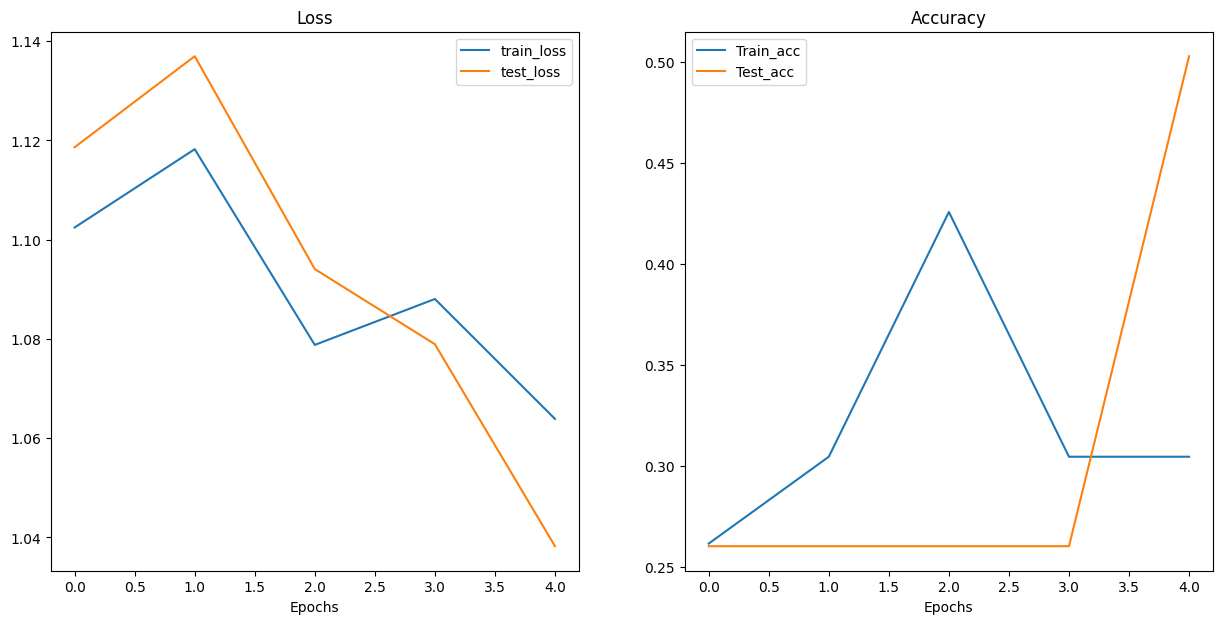

In [51]:
plot_loss_curves(model_0_results)

## 8. Model 1: TinyVGG with Data Augmentation
Trying another modelling experiment, this time using the same model as before with some data augmentation.

### 8.1 Create transform with data augmentation

In [52]:
train_transform_trivial= transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform_simple= transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

### 8.2 Create a train and test `Dataset` and `DataLoader`

In [53]:
# Train and Test Datasets 
train_data_augmented= datasets.ImageFolder(root=train_dir,
                                 transform=train_transform_trivial)

test_data_augmented= datasets.ImageFolder(root=test_dir,
                                          transform= test_transform_simple)

# Train and Test DataLoader
train_dataloader_augmented= DataLoader(dataset= train_data_augmented,
                                       batch_size= BATCH_SIZE,
                                       shuffle= True,
                                       num_workers= NUM_WORKERS)

test_dataloader_augmented= DataLoader(dataset= test_data_augmented,
                                      batch_size= BATCH_SIZE,
                                      shuffle= False,
                                      num_workers= NUM_WORKERS)

In [54]:
model_1= TinyVGG(input_shape=3,
                 output_shape= len(test_data_augmented),
                 hidden_units=10)
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier_layer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=75, bias=True)
  )
)

### 8.3 Training model_1

In [55]:
# Train

EPOCHS= 5
start_time= timer()
model_1_results= train(model= model_1,
                       train_dataloader= train_dataloader_augmented,
                       test_dataloader= test_dataloader_augmented,
                       optimizer= torch.optim.Adam(params= model_1.parameters(), lr=0.001),
                       loss_fn= nn.CrossEntropyLoss(),
                       epochs= EPOCHS,
                       device= device)
end_time= timer()
total_time = end_time- start_time
print(f"Training time on {device}: {total_time:.3f} seconds.")

 20%|██        | 1/5 [00:14<00:59, 14.91s/it]

Epoch: 0 | Train Loss: 3.5878 | Train Accuracy: 25.00% | Test Loss: 2.2440 | Test Accuracy: 19.79%


 40%|████      | 2/5 [00:31<00:47, 15.91s/it]

Epoch: 1 | Train Loss: 1.4420 | Train Accuracy: 31.64% | Test Loss: 1.0518 | Test Accuracy: 34.00%


 60%|██████    | 3/5 [00:46<00:30, 15.46s/it]

Epoch: 2 | Train Loss: 1.1210 | Train Accuracy: 39.45% | Test Loss: 1.4469 | Test Accuracy: 19.79%


 80%|████████  | 4/5 [01:01<00:15, 15.19s/it]

Epoch: 3 | Train Loss: 1.2182 | Train Accuracy: 41.41% | Test Loss: 1.1706 | Test Accuracy: 26.04%


100%|██████████| 5/5 [01:15<00:00, 15.19s/it]

Epoch: 4 | Train Loss: 1.2139 | Train Accuracy: 30.47% | Test Loss: 1.0256 | Test Accuracy: 54.17%
Training time on cuda: 75.931 seconds.


### 8.4 Plotting Loss Curves of model_1

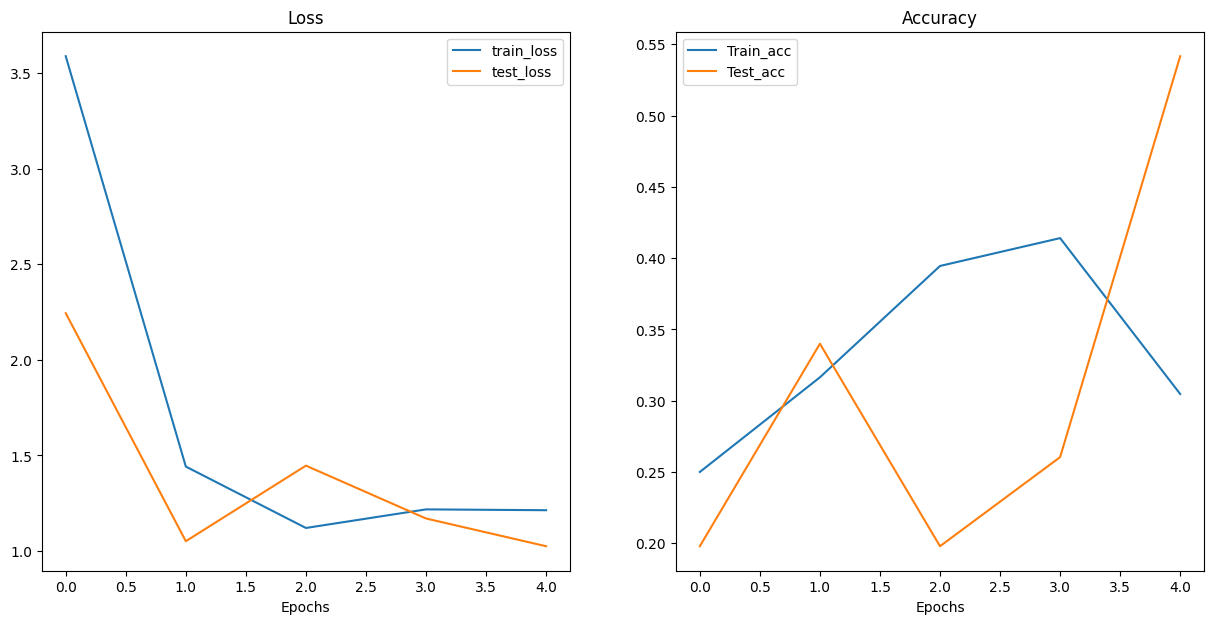

In [56]:
plot_loss_curves(model_1_results)

## 9. Compare model results
After evaluating our modelling experiments on their own, its important to compare them to each other.

There are a few different ways of doing them:
1. Hard Codin
2. PyTorch Tensorboard- https://pytorch.org/docs/stable/tensorboard.html
3. Weights and Bias- https://wandb.ai/site/experiment-tracking
4. MLflow- https://mlflow.org/

In [57]:
import pandas as pd
model_0_df= pd.DataFrame(model_0_results)
model_1_df= pd.DataFrame(model_1_results)

model_0_df

,train_loss,train_acc,test_loss,test_acc
0,1.102463,0.261719,1.118633,0.260417
1,1.118243,0.304688,1.136977,0.260417
2,1.078802,0.425781,1.094082,0.260417
3,1.088056,0.304688,1.078944,0.260417
4,1.063892,0.304688,1.038236,0.502841


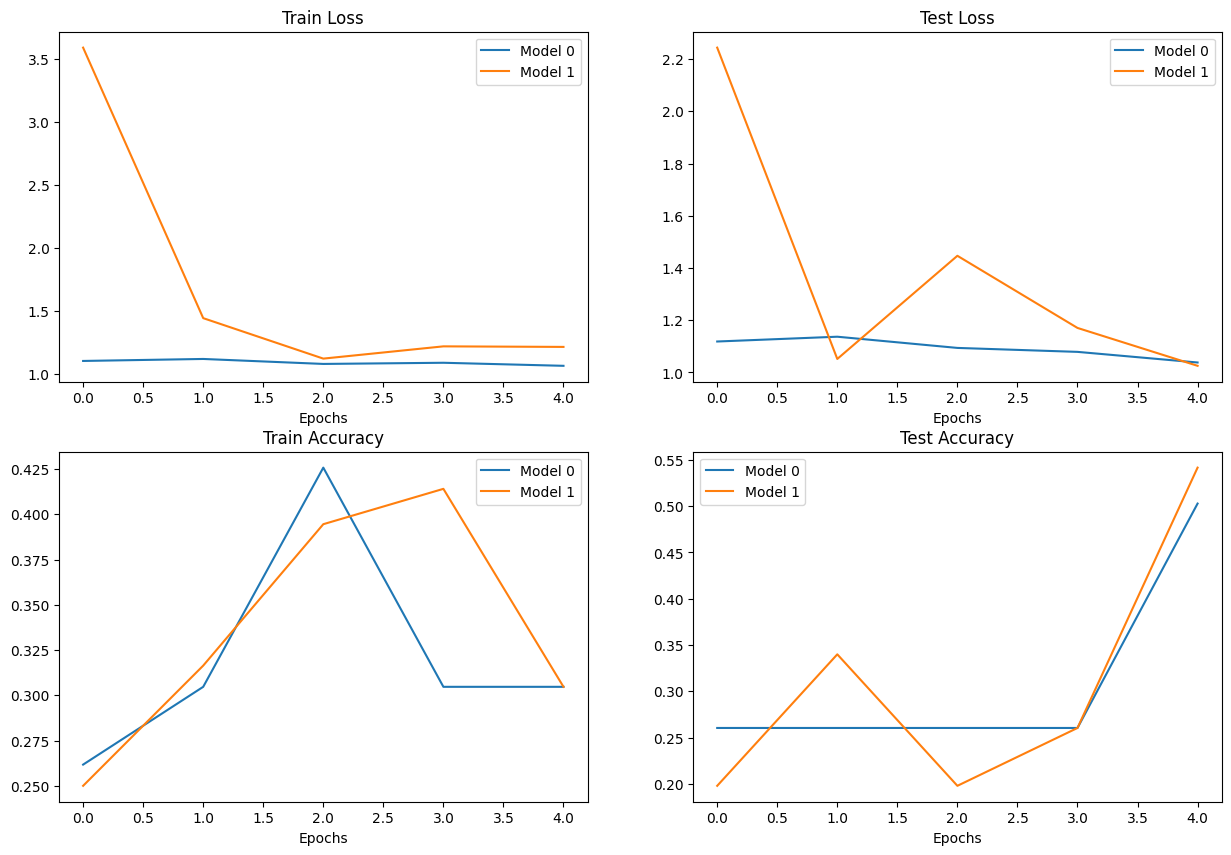

In [58]:
# Setup a plot
plt.figure(figsize=(15,10))

# Get number of epochs
epochs= range(len(model_0_df))

# Plot train loss 
plt.subplot(2,2,1)
plt.plot(epochs, model_0_df['train_loss'], label='Model 0')
plt.plot(epochs, model_1_df['train_loss'], label='Model 1')
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.legend()

# Plot test loss
plt.subplot(2,2,2)
plt.plot(epochs, model_0_df['test_loss'], label='Model 0')
plt.plot(epochs, model_1_df['test_loss'], label='Model 1')
plt.title('Test Loss')
plt.xlabel('Epochs')
plt.legend()

# Plot train acc
plt.subplot(2,2,3)
plt.plot(epochs, model_0_df['train_acc'], label='Model 0')
plt.plot(epochs, model_1_df['train_acc'], label='Model 1')
plt.title('Train Accuracy')
plt.xlabel('Epochs')
plt.legend()

# Plot test acc
plt.subplot(2,2,4)
plt.plot(epochs, model_0_df['test_acc'], label='Model 0')
plt.plot(epochs, model_1_df['test_acc'], label='Model 1')
plt.title('Test Accuracy')
plt.xlabel('Epochs')
plt.legend()

## 10. Making predictions on Custom Data
Although we've made trained a model on custom data... how do you make a prediction on a sample/ image that's not in either training or testing dataset.

In [59]:
# Download custom image
import requests

# Setup custom image path
custom_image_path= data_path/ "04-pizza-dad.jpeg"

# Download the image if it doesn't already exists
if not custom_image_path.is_file():
    with open(custom_image_path, 'wb') as f:
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

data\04-pizza-dad.jpeg already exists, skipping download.


### 10.1 Converting the custom image into tensor

In [60]:
import torchvision

custom_image= torchvision.io.read_image(str(custom_image_path)).type(torch.float)/255
print(f"Custom image tensor: {custom_image}")
print(f"Custom image shape: {custom_image.shape}")
print(f"Custom image dtype: {custom_image.dtype}")

Custom image tensor: tensor([[[0.6039, 0.6863, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6549, 0.7059,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6706,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7412, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7098, 0.7608,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7255,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4157, 0.4078, 0.4000],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4118, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4588, 0.5412, 0.5686,  ..., 0.0667, 0.0549, 0.0392],
         [0.4275, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  ..

(-0.5, 3023.5, 4031.5, -0.5)

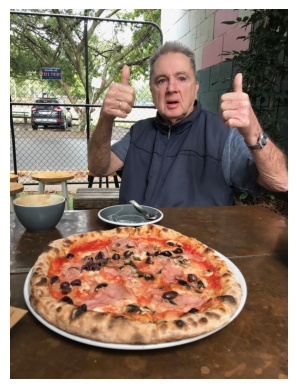

In [61]:
plt.imshow(custom_image.permute(1,2,0))
plt.axis(False)

### 10.2 Making a prediction on a custom image with a trained PyTorch Model

In [62]:
custom_image_transform= transforms.Compose([
    transforms.Resize(size=(64,64))
])
custom_image_transformed= custom_image_transform(custom_image)

C:\Users\Kushagra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


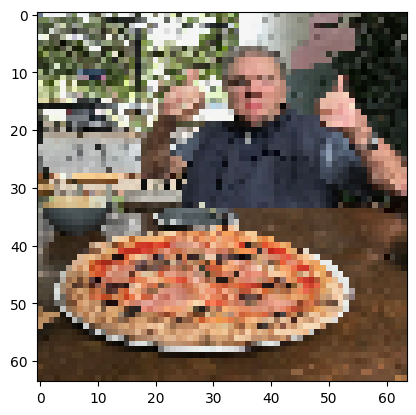

In [63]:
plt.imshow(custom_image_transformed.permute(1,2,0))

In [64]:
model_1.eval()
with torch.inference_mode():
    # Add an extra dimension to image
    custom_image_transformed_with_batch_size = custom_image_transformed.unsqueeze(dim=0)
    
    # Print out different shapes
    print(f"Custom image transformed shape: {custom_image_transformed.shape}")
    print(f"Unsqueezed custom image shape: {custom_image_transformed_with_batch_size.shape}")
    
    # Make a prediction on image with an extra dimension
    custom_image_pred = model_1(custom_image_transformed.unsqueeze(dim=0).to(device))

Custom image transformed shape: torch.Size([3, 64, 64])
Unsqueezed custom image shape: torch.Size([1, 3, 64, 64])


In [65]:
# Print out prediction logits
print(f"Prediction logits: {custom_image_pred}")

# Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
print(f"Prediction probabilities: {custom_image_pred_probs}")

# Convert prediction probabilities -> prediction labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
print(f"Prediction label: {custom_image_pred_label}")

Prediction logits: tensor([[  7.5488,   7.3518,   7.7342, -10.8944, -10.8085, -11.1519, -10.8839,
         -10.8739, -10.5492, -11.1483, -10.5187, -10.8383, -11.2846, -10.8014,
         -11.0246, -10.9927, -10.9985, -10.8636, -11.0590, -11.0318, -10.9659,
         -10.9660, -11.0028, -11.0319, -11.0615, -10.9672, -10.6638, -10.8568,
         -10.7586, -10.7909, -10.8800, -10.8212, -10.8189, -10.7231, -11.0143,
         -11.1336, -10.8891, -10.7228, -10.7092, -10.4878, -10.9637, -10.5403,
         -10.8872, -10.9793, -11.0328, -11.0251, -10.9228, -10.8836, -11.0154,
         -11.2431, -11.2884, -10.9861, -10.9684, -11.2358, -10.7711, -10.7078,
         -10.8586, -10.9709, -10.6335, -10.9509, -11.0226, -10.9470, -11.0245,
         -10.8529, -10.5427, -11.0253, -10.9939, -10.7766, -10.8759, -11.0381,
         -10.7840, -10.7447, -10.9409, -11.0999, -10.9889]], device='cuda:0')
Prediction probabilities: tensor([[3.3059e-01, 2.7148e-01, 3.9793e-01, 3.2324e-09, 3.5224e-09, 2.4986e-09,
      

In [66]:
# Find the predicted label
custom_image_pred_class = class_names[custom_image_pred_label.cpu()] # put pred label to CPU, otherwise will error
custom_image_pred_class

'sushi'

In [67]:
# The values of the prediction probabilities are quite similar
custom_image_pred_probs

tensor([[3.3059e-01, 2.7148e-01, 3.9793e-01, 3.2324e-09, 3.5224e-09, 2.4986e-09,
         3.2665e-09, 3.2994e-09, 4.5648e-09, 2.5076e-09, 4.7063e-09, 3.4189e-09,
         2.1881e-09, 3.5475e-09, 2.8379e-09, 2.9299e-09, 2.9128e-09, 3.3335e-09,
         2.7418e-09, 2.8173e-09, 3.0093e-09, 3.0089e-09, 2.9003e-09, 2.8172e-09,
         2.7349e-09, 3.0053e-09, 4.0709e-09, 3.3564e-09, 3.7025e-09, 3.5849e-09,
         3.2793e-09, 3.4779e-09, 3.4858e-09, 3.8364e-09, 2.8670e-09, 2.5446e-09,
         3.2496e-09, 3.8375e-09, 3.8901e-09, 4.8539e-09, 3.0161e-09, 4.6056e-09,
         3.2558e-09, 2.9692e-09, 2.8146e-09, 2.8363e-09, 3.1420e-09, 3.2674e-09,
         2.8641e-09, 2.2809e-09, 2.1797e-09, 2.9490e-09, 3.0018e-09, 2.2976e-09,
         3.6565e-09, 3.8955e-09, 3.3502e-09, 2.9943e-09, 4.1959e-09, 3.0547e-09,
         2.8434e-09, 3.0667e-09, 2.8381e-09, 3.3693e-09, 4.5945e-09, 2.8357e-09,
         2.9262e-09, 3.6363e-09, 3.2929e-09, 2.7998e-09, 3.6097e-09, 3.7544e-09,
         3.0854e-09, 2.6320e


### 11.3 Putting custom image prediction together: building a function
Doing all of the above steps every time you'd like to make a prediction on a custom image would quickly become tedious.

So let's put them all together in a function we can easily use over and over again.

Specifically, let's make a function that:

1. Takes in a target image path and converts to the right datatype for our model (torch.float32).
2. Makes sure the target image pixel values are in the range [0, 1].
3. Transforms the target image if necessary.
4. Makes sure the model is on the target device.
5. Makes a prediction on the target image with a trained model (ensuring the image is the right size and on the same device as the model).
6. Converts the model's output logits to prediction probabilities.
7. Converts the prediction probabilities to prediction labels.
8. Plots the target image alongside the model prediction and prediction probability.

In [68]:
def pred_and_plot_image(model: torch.nn.Module, 
                        image_path: str, 
                        class_names: List[str] = None, 
                        transform=None,
                        device: torch.device = device):
    """Makes a prediction on a target image and plots the image with its prediction."""
    
    # 1. Load in image and convert the tensor values to float32
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)
    
    # 2. Divide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255. 
    
    # 3. Transform if necessary
    if transform:
        target_image = transform(target_image)
    
    # 4. Make sure the model is on the target device
    model.to(device)
    
    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)
    
        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))
        
    # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 7. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)
    
    # 8. Plot the image alongside the prediction and prediction probability
    plt.imshow(target_image.squeeze().permute(1, 2, 0)) # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else: 
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False)

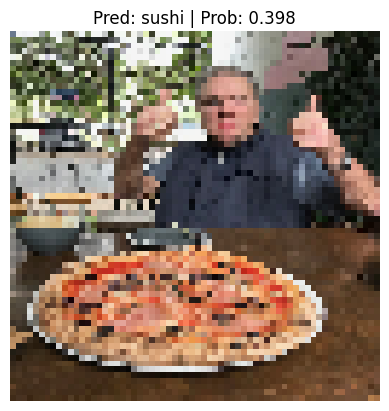

In [69]:
# Pred on our custom image
pred_and_plot_image(model=model_1,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)